In [1]:
from virusPropagationModel import *
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import os
import timeit
import matplotlib.cm as cm

In [24]:
modeledWorld1 = ModeledPopulatedWorld(1000,10, world_from_file=True, geofile_name='datafiles/Buildings_Gangelt_MA_3.csv', agent_agent_infection=True)
print('Number of agents: '+ str(modeledWorld1.number_of_people))
print('distrution of initialized locations: ' + str(modeledWorld1.get_distribution_of_location_types()))

Number of agents: 1460
distrution of initialized locations: {'home': 496, 'work': 52, 'public': 11, 'school': 2, 'hospital': 1, 'cemetery': 1}


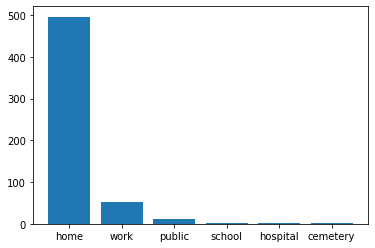

In [25]:
modeledWorld1.plot_distribution_of_location_types()

In [26]:
simulation1 = Simulation(modeledWorld1,720,run_immediately=False)
simulation1.change_agent_attributes({'all':{'behaviour_as_infected':{'value':0.5,'type':'replacement'}}})

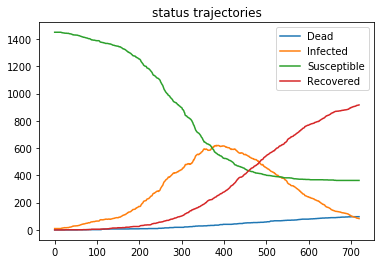

In [27]:
simulation1.simulate()
simulation1.plot_status_timecourse()

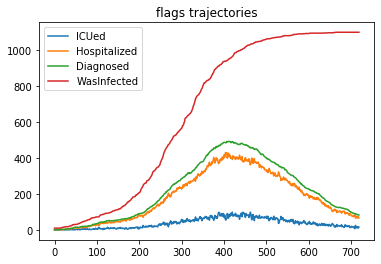

In [28]:
simulation1.plot_flags_timecourse()

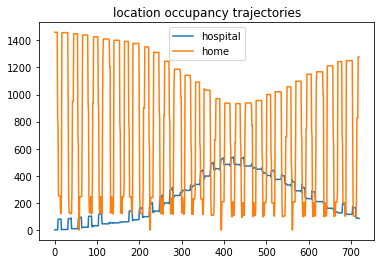

In [29]:
simulation1.plot_location_type_occupancy_timecourse(specific_types=['hospital','home'])

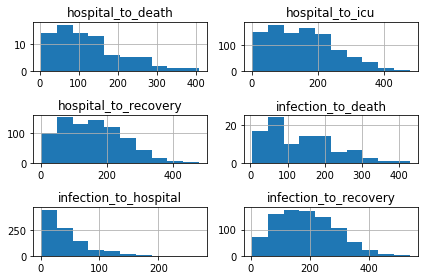

In [30]:
simulation1.plot_distributions_of_durations()

In [31]:
simulation1.export_time_courses_as_csvs(identifier='testing') 
# Exports the CSVs to the outputs folder.
# Files marked with the identifier 'testing' get automatically deleted by the testrunner.
# Use a different identifier name if you want your outputs to remain in the folder.

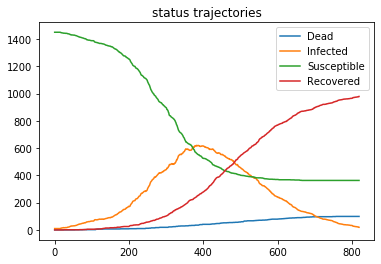

In [32]:
simulation2 = Simulation(simulation1,100) # Now Simulation class objects can be used for subsequent simulation (nested)
simulation2.plot_status_timecourse()

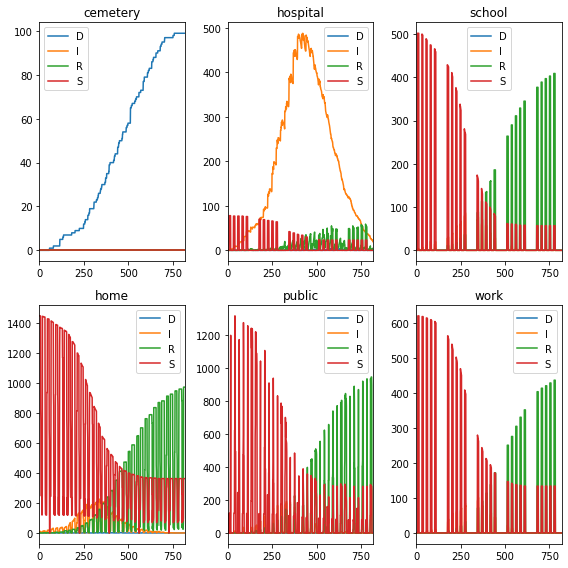

<Figure size 432x288 with 0 Axes>

In [33]:
simulation2.plot_status_at_location()


In [34]:
#now we can save and load worlds and simulations (exported to the folder saved_objects)
#modeledWorld1.save('testingmyfirstworld')
#loadedWorld1 = load_simulation_object('testingmyfirstworld')
#simulationFromLoadedWorld1 = Simulation(loadedWorld1,100)
#simulationFromLoadedWorld1.save('testingmyfirstsimulation')
#loadedSimulation = load_simulation_object('testingmyfirstsimulation')
#loadedSimulation.plot_status_timecourse()

In [ ]:
simulation1.map_status_at_loc(save_figure=True,time_steps=800)

D:\TBP\corona\corona_model\VPM_plotting.py:202: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,10))


In [36]:
# removes files saved in the cells in this notebook
for file in glob.glob("*/testing*"):
    os.remove(file)